# Read output files

In [1]:
import awkward as ak
import numpy as np
import os, uproot, yaml, correctionlib, gc
from glob import glob

In [11]:
source = 'glopart_v2'
base = f'/eos/user/d/dfu/bbgamma_output/{source}'

filepath = {
    year: {
        r'Top+$\gamma$': sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['TTGJets']], []),
        r'Z+$\gamma$':  sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['ZGToLLG', 'ZGToJJG']], []),
        r'W+$\gamma$': sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['WGToJJG', 'WGToLNuG']], []),
        r'Non-prompt $\gamma$': sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['ST', 'TTJets', 'ZJetsToNuNu', 'ZJetsToLL', 'ZJetsToQQ', 'WJetsToLNu', 'WJetsToQQ', 'QCD']], []),
        r'QCD+$\gamma$': sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['GJets']], []),
        'data': sum([glob(f'{base}/data/{year}/{channel}/*') for channel in ["EGamma" if year=="2018" else "SinglePhoton"]], []),
    } for year in ['2016pre', '2016post', '2017', '2018']
}

BKG = set([k for k in filepath['2018'].keys()]) - set(['data'])

for year in filepath:
    for job_dir in sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['ZpToHG', 'GluGluToZG']], []):
        mass = int(job_dir.split('M')[1].split('_')[0])
        m = mass//1000 if mass%1000 == 0 else mass/1000
        if 'ZpToHG' in job_dir:
            channel = r'$Z^\prime$'+f'({m}TeV,N)'+r'$\to H\gamma$'
        elif '_0p014' in job_dir: 
            channel = f'S({m}TeV,N)'+r'$\to Z\gamma$'
        elif '_5p6' in job_dir: 
            channel = f'S({m}TeV,W)'+r'$\to Z\gamma$'
        elif '_10p0' in job_dir: 
            channel = f'S({m}TeV,VW)'+r'$\to Z\gamma$'
        filepath[year][channel] = [job_dir]

events = {year: {k: [] for k in filepath[year]} for year in filepath}


for year in filepath:
    for channel, folders in filepath[year].items():
        for folder in folders:
            mode = '_'.join(folder.split('/')[-4:-1])
            if len(os.listdir(folder)) != 2:
                continue
            if os.path.exists(os.path.join(folder, f'{mode}.parq')):
                os.rename(os.path.join(folder, f'{mode}.parq'), os.path.join(folder, f'{mode}.parquet'))
            folder_events = ak.from_parquet(os.path.join(folder, f'{mode}.parquet'))
            with open(os.path.join(folder, f'{mode}.yaml'), 'r', encoding='utf-8') as f:
                folder_stats = yaml.safe_load(f)
            if 'mc' in mode and ak.mean(folder_events.event_final_weight) > np.sqrt(folder_stats['final']):
                continue

            events[year][channel].append(folder_events)
        if len(events[year][channel]) == 0:
            del events[year][channel]
        else:
            events[year][channel] = ak.concatenate(events[year][channel], axis=0)

## Decomposite signal

In [12]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'$Z^\prime$(1TeV,N)$\to H(bb)\gamma$': 'red',
    r'$Z^\prime$(2TeV,N)$\to H(bb)\gamma$': 'purple',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'S(2TeV,N)$\to Z(bb)\gamma$': 'blue',
    r'S(2TeV,W)$\to Z(bb)\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'S(2TeV,VW)$\to Z(bb)\gamma$': 'cyan',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

In [13]:
def decomposite(signal: ak.Array):
    HWW_decay_mode = ak.fill_none(signal.gen_HWW_decay_mode, 0)

    signal['HWW_4q'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode >= 32)
    
    signal['HWW_qqlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode > 16) & (HWW_decay_mode < 32)
    
    signal['HWW_lvlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode <= 16)

    return signal

DECOMPOSITE = True
if DECOMPOSITE:
    for y in events:
        for c in list(events[y].keys()):
            if c in BKG or c=='data':
                continue
            if r'H\gamma' in c:
                events[y][c.replace('H', 'H(bb)')] = events[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]
                #events[y][c.replace('H', 'H(cc)')] = events[y][c][events[y][c]['gen_ZpToH(cc)Gamma']]
                del events[y][c]
            if r'Z\gamma' in c:
                events[y][c.replace('Z', 'Z(bb)')] = events[y][c][events[y][c]['gen_GluGluToZ(bb)Gamma']]
                #events[y][c.replace('Z', 'Z(cc)')] = events[y][c][events[y][c]['gen_GluGluToZ(cc)Gamma']]
                del events[y][c]

In [14]:
nlo = correctionlib.CorrectionSet.from_file('../src/parameters/nlo_kfactor.json')
list(nlo.keys())

['gjets_nlo_kfactor_ewk',
 'gjets_nlo_kfactor_qcd',
 'wjets_nlo_kfactor_ewk',
 'wjets_nlo_kfactor_qcd',
 'zjets_nlo_kfactor_ewk',
 'zjets_nlo_kfactor_qcd']

In [15]:
#weight = {y: {c: events[y][c].event_final_weight for c in events[y]} for y in events}

weight = {y: {} for y in events}
for y in events:
    for c in events[y]:
        if c == r'QCD+$\gamma$':
            weight[y][c] = events[y][c].event_final_weight * nlo['gjets_nlo_kfactor_qcd'].evaluate(events[y][c]['AK8jet_pt'])
        elif c == r'W+$\gamma$':
            weight[y][c] = events[y][c].event_final_weight * nlo['wjets_nlo_kfactor_qcd'].evaluate(events[y][c]['AK8jet_pt'])
        elif c == r'Z+$\gamma$':
            weight[y][c] = events[y][c].event_final_weight * nlo['zjets_nlo_kfactor_qcd'].evaluate(events[y][c]['AK8jet_pt'])
        else:
            weight[y][c] = events[y][c].event_final_weight


In [ ]:
#for year in events:
#    weight[year]['bkg'] = ak.concatenate([weight[year][c] for c in BKG], axis=0)
#    events[year]['bkg'] = ak.concatenate([events[year][c] for c in BKG], axis=0)
gc.collect()
weight['2016'] = {k: ak.concatenate([weight[y][k] for y in ['2016pre', '2016post']], axis=0) for k in weight['2016pre']}
events['2016'] = {k: ak.concatenate([events[y][k] for y in ['2016pre', '2016post']], axis=0) for k in events['2016pre']}

In [10]:
gc.collect()

weight['Run2'] = {k: ak.concatenate([weight[y][k] for y in ['2016', '2017', '2018']], axis=0) for k in weight['2018']}


In [78]:
gc.collect()

events['Run2'] = {k: ak.concatenate([events[y][k] for y in ['2016', '2017', '2018']], axis=0) for k in events['2018']}

In [2]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#3f90da', '#ffa90e', '#bd1f01', '#94a4a2', '#832db6', '#a96b59', '#e76300', '#b9ac70', '#717581', '#92dadd'])


NameError: name 'cycler' is not defined

# Start plotting

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
from matplotlib.cm import get_cmap

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#3f90da', '#ffa90e', '#bd1f01', '#94a4a2', '#832db6', '#a96b59', '#e76300', '#b9ac70', '#717581', '#92dadd'])

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])

    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

/tmp/ipykernel_143567/1903999373.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


## Data comparison

In [ ]:
def data_compare_plot(arrays, plot_name: str, x_name: str, cuts=None, bins=40, x_min=0, x_max=3000, density=True, overflow=True, underflow=False):
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    #plt.grid()
    hep.cms.label(data=True, ax=ax, fontsize=18)
    
    ## analyze

    ## plot
    for (k, v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        hep.histplot(h, bins=hist.axes[0].edges, xerr=bin_width/2, yerr=error_bar(h, var, mode='data'), label=k, histtype='step', density=density, stack=False, ax=ax, linewidth=2)
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    if 'eta' in plot_name:
        ax.set_ylim(1e-2, ax.get_ylim()[1]*5)
    else:
        ax.set_ylim(1e-8, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=18)

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/data_compare_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
arrays={k: events[k]['data'].photon_pt for k in events}
data_compare_plot(arrays, 'photon_pt', x_name=r'$p_T^{\gamma}$')

arrays={k: events[k]['data'].photon_eta for k in events}
data_compare_plot(arrays, 'photon_eta', x_name=r'$\eta_{\gamma}$', x_min=-3, x_max=3)

arrays={k: events[k]['data'].photon_phi for k in events}
data_compare_plot(arrays, 'photon_phi', x_name=r'$\phi_\gamma$', x_min=-4, x_max=4)

arrays={k: events[k]['data'].AK8jet_pt for k in events}
data_compare_plot(arrays, 'AK8jet_pt', x_name=r'$p_T^j$')

arrays={k: events[k]['data'].AK8jet_eta for k in events}
data_compare_plot(arrays, 'AK8jet_eta', x_name=r'$\eta_j$', x_min=-3, x_max=3)

arrays={k: events[k]['data'].AK8jet_phi for k in events}
data_compare_plot(arrays, 'AK8jet_phi', x_name=r'$\phi_j$', x_min=-4, x_max=4)

arrays={k: events[k]['data'].AK8jet_msoftdrop for k in events}
data_compare_plot(arrays, 'AK8jet_msoftdrop', x_name=r'$m_{SD}^j$', x_min=0, x_max=300)

## Data-MC comparison

In [ ]:
hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, year='Run2', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, log_y=True, x_axis=None, bin_width=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int(round((x_max-x_min)/bin_width, 0))
    else:
        bin_width = (x_max-x_min)/bins

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    #ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, ax=ax, lumi=round(LUMI[year], 0), fontsize=18, llabel='Preliminary')
    
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        elif k in SIG or k=='data':
            individual['h'][k] = h
            individual['var'][k] = var

    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], mode='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
    for k in SIG:  # signal
        h=individual['h'][k]
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax)
        y = h / np.sqrt(bkg_h+1)
        hep.histplot(y, bins=hist.axes[0].edges, yerr=0, label=k, histtype='step', density=density, stack=False, ax=ax2)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(3e-1 if log_y else 0, ax.get_ylim()[1]**1.5 * 10**0.5)
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    y_label = 'Events' if density==False else 'A.U.'
    ax.set_ylabel(f'{y_label} / {bin_width}'+' GeV' if 'GeV' in x_name else '', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    ax1.set_ylim(0.5, 1.5)
    ax1.set_ylabel('Data/MC', ha='center', fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=15)

    ## finalizing
    suffix = '_AU' if density else ''
    os.makedirs(f'./plots/{year}', exist_ok=True)
    plt.savefig(f"./plots/{year}/{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

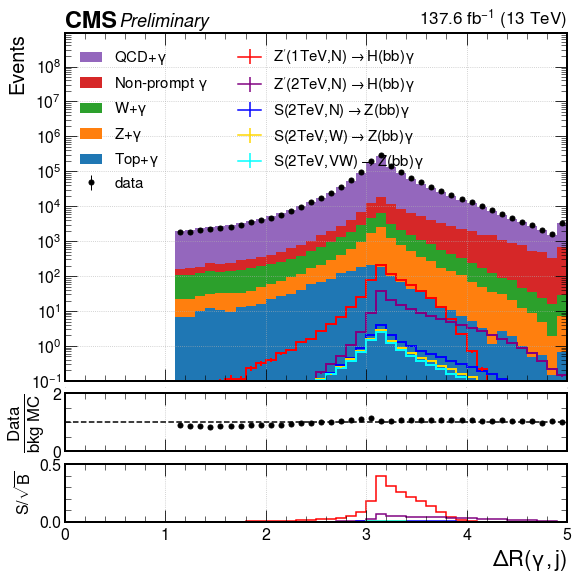

In [101]:
y = 'Run2'
arrays={k: events[y][k]['photon-jet_deltaR'] for k in events[y]}
indiv = data_mc_compare_plot(arrays, x_name=r'$\Delta R(\gamma, j)$', plot_name='deltaR', x_max=5, x_min=0, bins=50, weight=weight[y], year=y)

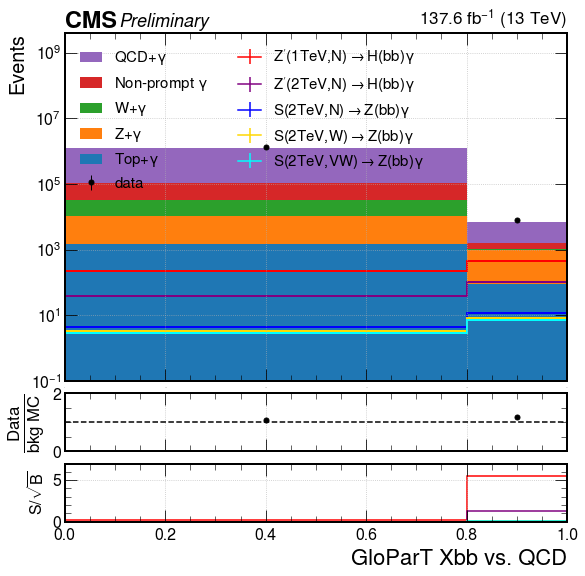

In [102]:
arrays={k: events[y][k].AK8jet_Xbb_tagger for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_Xbb_tagger', x_name=r'GloParT Xbb vs. QCD', x_axis=bh.axis.Variable([0, 0.8, 1]), x_min=0, x_max=1, weight=weight[y], year=y, log_y=True)

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)


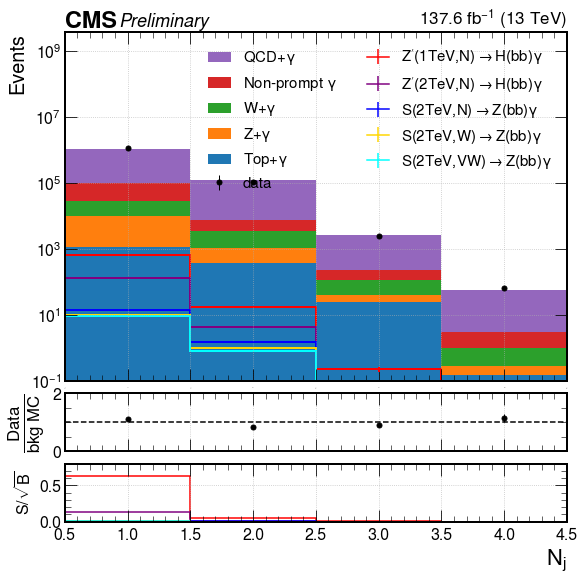

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

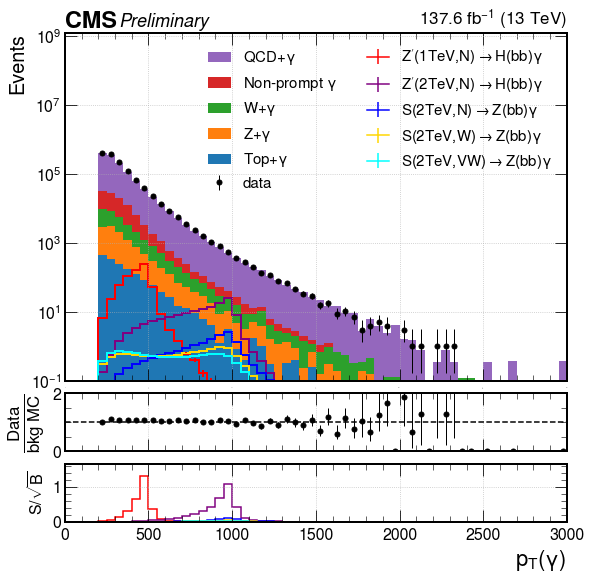

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

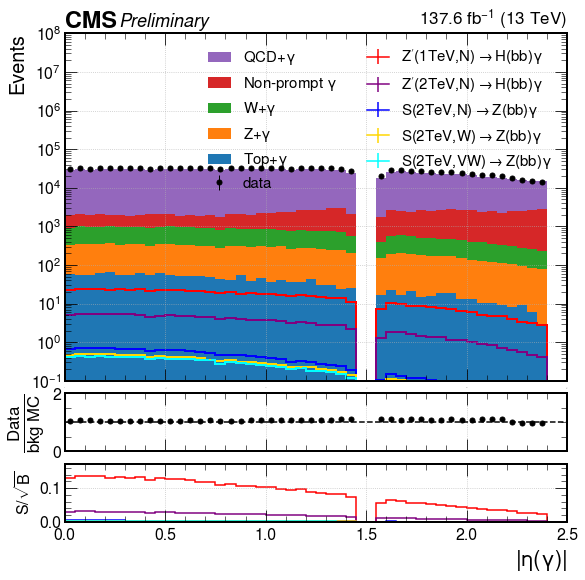

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

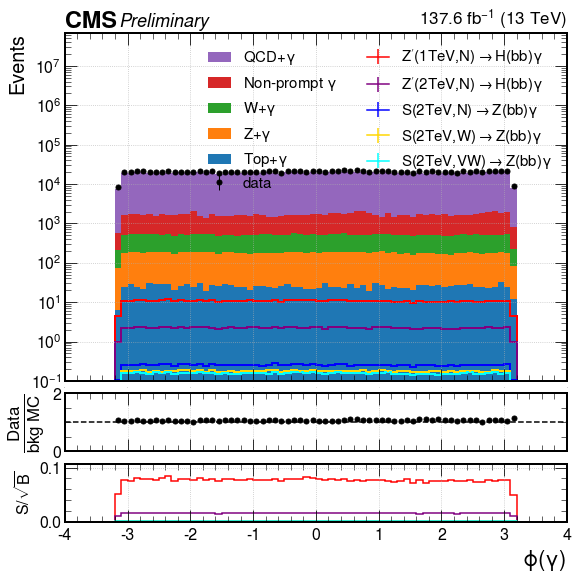

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

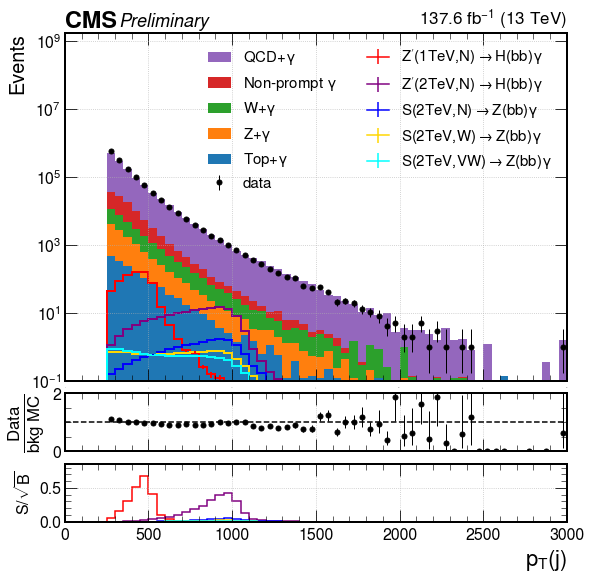

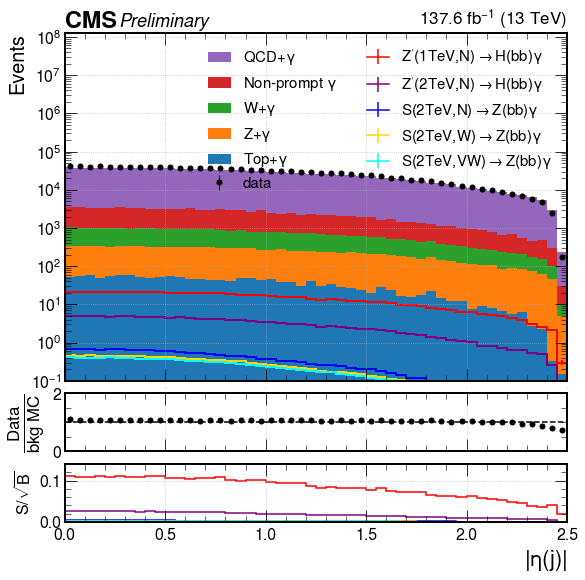

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

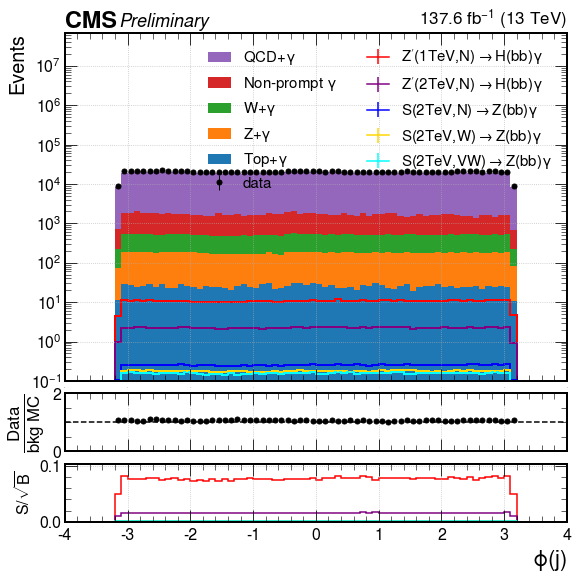

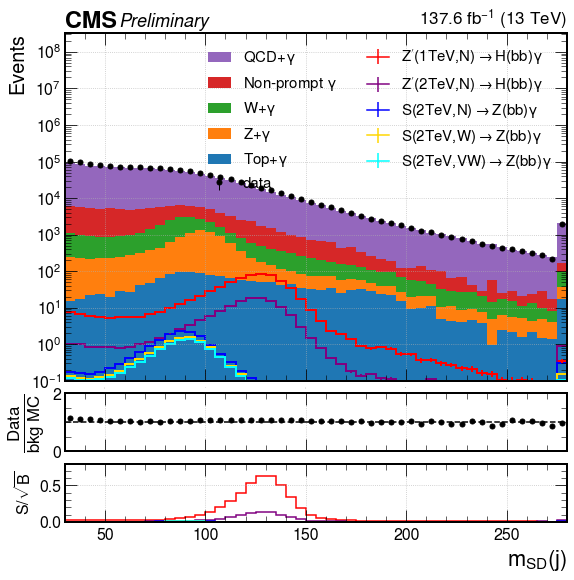

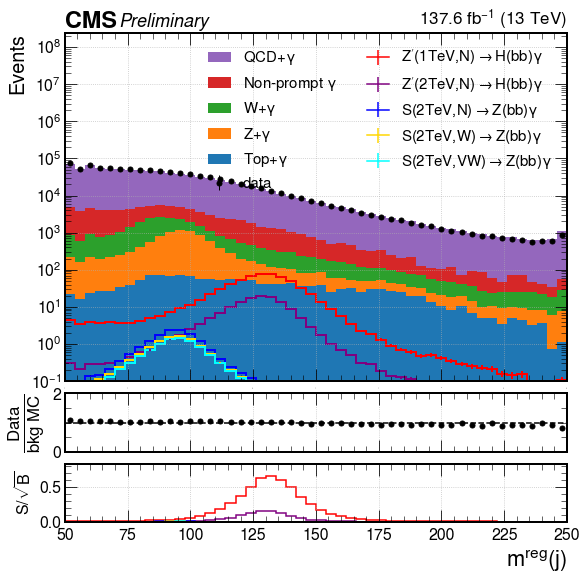

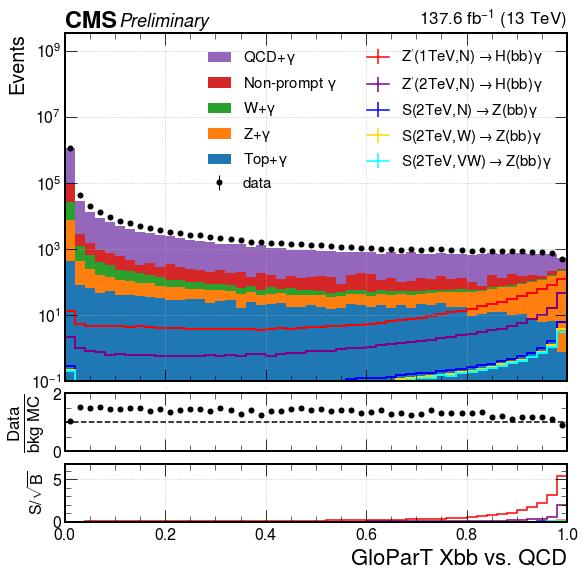

In [ ]:
y='Run2'
arrays={k: events[y][k].nAK8jet for k in events[y]}
data_mc_compare_plot(arrays, plot_name='nAK8jet', x_name=r'$N_j$', x_max=4.5, x_min=0.5, bins=4, weight=weight[y], year=y)
arrays={k: events[y][k].photon_pt for k in events[y]}
data_mc_compare_plot(arrays, plot_name='photon_pt', x_name=r'$p_T(\gamma)$ (GeV)', x_max=3000, x_min=0, bins=60, weight=weight[y], year=y)
arrays={k: np.abs(events[y][k].photon_eta) for k in events[y]}
data_mc_compare_plot(arrays, plot_name='photon_eta', x_name=r'$|\eta(\gamma)|$', x_max=2.5, x_min=0, bins=50, weight=weight[y], year=y)
arrays={k: events[y][k].photon_phi for k in events[y]}
data_mc_compare_plot(arrays, plot_name='photon_phi', x_name=r'$\phi(\gamma)$', x_max=4, x_min=-4, bins=80, weight=weight[y], year=y)
arrays={k: (events[y][k].AK8jet_pt if k=='data' else events[y][k].AK8jet_pt) for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_pt', x_name=r'$p_T(j)$ (GeV)', x_max=3000, x_min=0, bins=60, weight=weight[y], year=y)
arrays={k: np.abs(events[y][k].AK8jet_eta) for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_eta', x_name=r'$|\eta(j)|$', x_max=2.5, x_min=0, bins=50, weight=weight[y], year=y)
arrays={k: events[y][k].AK8jet_phi for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_phi', x_name=r'$\phi(j)$', x_max=4, x_min=-4, bins=80, weight=weight[y], year=y)
arrays={k: events[y][k].AK8jet_msoftdrop for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_msoftdrop', x_name=r'$m^{SD}_j$ (GeV)', x_max=280, x_min=30, bins=50, weight=weight[y], year=y, log_y=True)
arrays={k: events[y][k].AK8jet_particleNet_mass for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_regressed_mass', x_name=r'$m_j$ (GeV)', x_max=250, x_min=50, bins=50, weight=weight[y], year=y, log_y=True)
arrays={k: events[y][k].AK8jet_Xbb_tagger for k in events[y]}
data_mc_compare_plot(arrays, plot_name='AK8jet_Xbb_tagger', x_name=r'Xbb score', x_max=1, x_min=0, bins=50, weight=weight[y], year=y, log_y=True)


/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: Ru

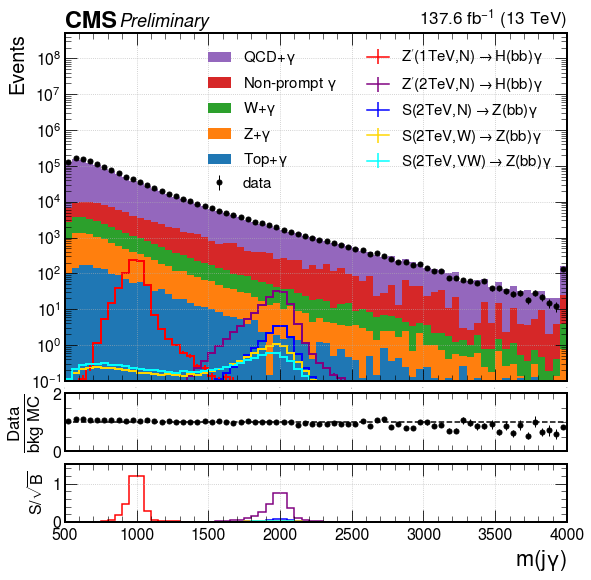

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)


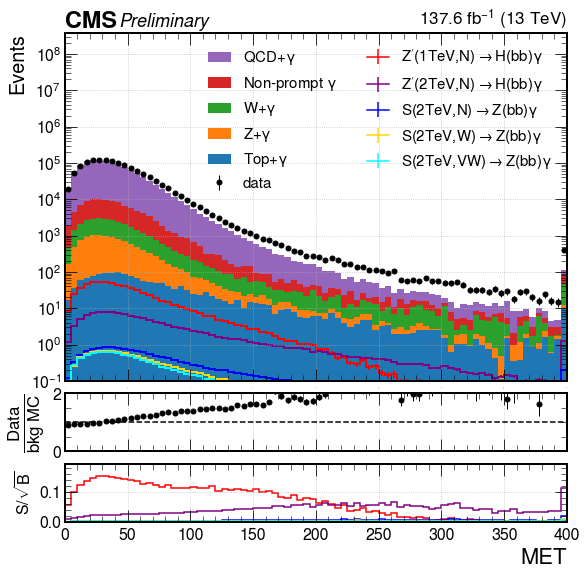

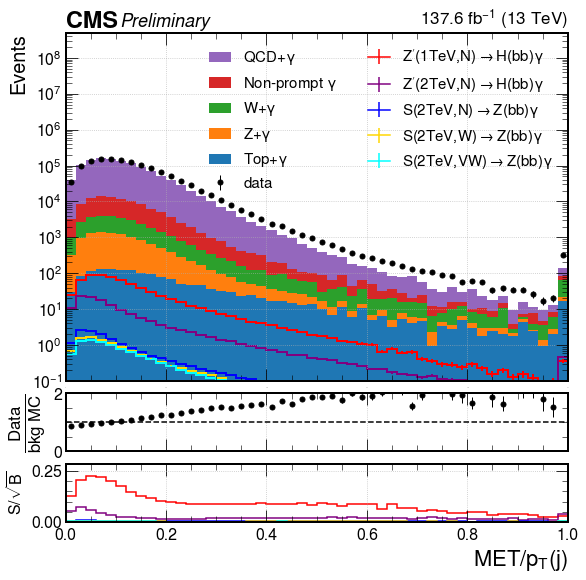

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

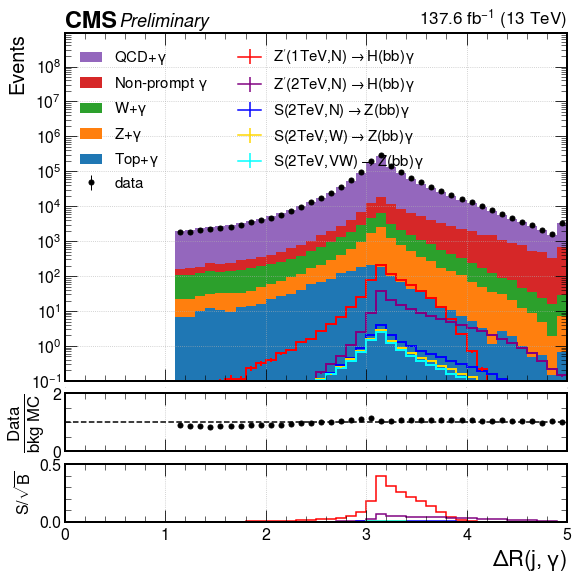

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)


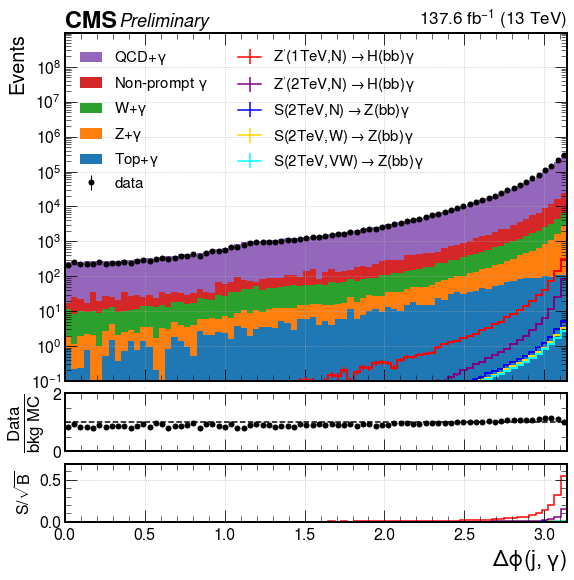

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)


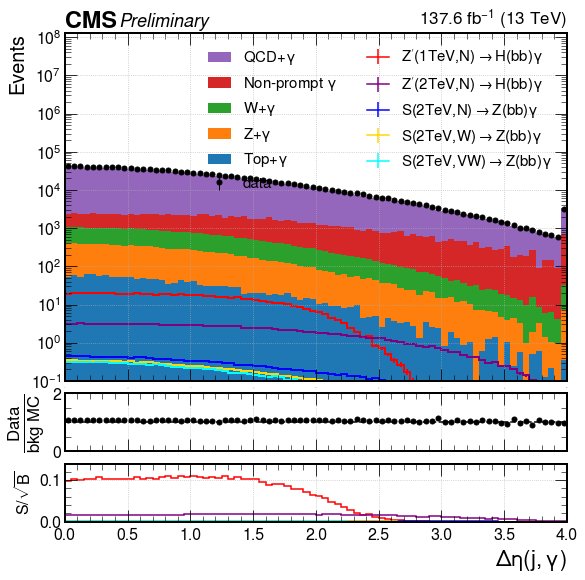

/tmp/ipykernel_143567/163449813.py:53: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in d

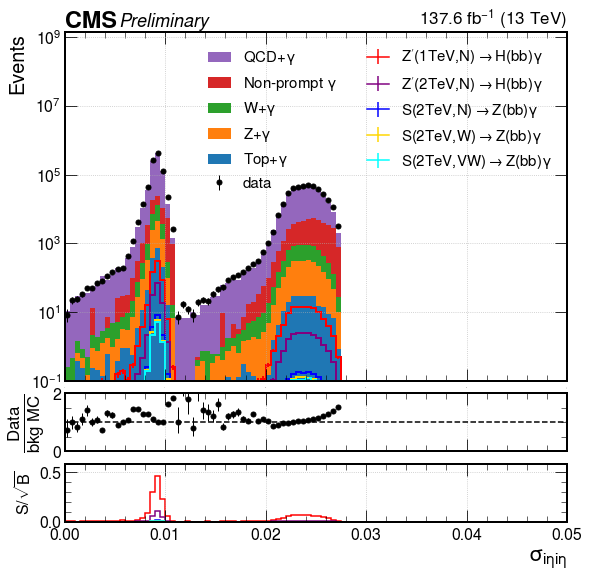

In [ ]:
y='Run2'
arrays={k: events[y][k]['photon+jet_mass'] for k in events[y]}
data_mc_compare_plot(arrays, x_name=r'$m_{j\gamma}$ (GeV)', plot_name='photon+jet_mass', x_max=4000, x_min=500, bins=70, weight=weight[y], year=y)
arrays={k: events[y][k]['event_MET_pt'] for k in events[y]}
data_mc_compare_plot(arrays, x_name=r'$p_T^{miss}$ (GeV)', plot_name='event_MET_pt', x_max=400, bins=80, weight=weight[y], year=y)
arrays={k: events[y][k].event_MET_pt/events[y][k].AK8jet_pt for k in events[y]}
data_mc_compare_plot(arrays, plot_name='MET_over_AK8jet_pt', x_name=r'$MET/p_T(j)$', x_max=1, x_min=0, bins=50, weight=weight[y], year=y)
arrays={k: events[y][k]['photon-jet_deltaR'] for k in events[y]}
data_mc_compare_plot(arrays, x_name=r'$\Delta R(j,\gamma)$', plot_name='photon-jet_deltaR', x_max=5, bins=50, weight=weight[y], year=y)
arrays={k: np.min([abs(events[y][k].photon_phi - events[y][k].AK8jet_phi), 2*np.pi - abs(events[y][k].photon_phi - events[y][k].AK8jet_phi)], axis=0) for k in events[y]}
data_mc_compare_plot(arrays, plot_name='photon-jet_delta_phi', x_name=r'$\Delta\phi(j, \gamma)$', x_max=np.pi, x_min=0, bins=80, weight=weight[y], year=y)
arrays={k: abs(events[y][k].photon_eta - events[y][k].AK8jet_eta) for k in events[y]}
data_mc_compare_plot(arrays, plot_name='photon-jet_delta_eta', x_name=r'$\Delta\eta(j, \gamma)$', x_max=4, x_min=0, bins=80, weight=weight[y], year=y)
arrays={k: np.min([abs(events[y][k].photon_phi - events[y][k].event_MET_phi), 2*np.pi - abs(events[y][k].photon_phi - events[y][k].event_MET_phi)], axis=0) for k in events[y]}
arrays={k: events[y][k]['photon_sieie'] for k in events[y]}
data_mc_compare_plot(arrays, plot_name='photon_sieie', x_name=r'$\sigma_{i\eta i\eta}$', x_max=0.05, x_min=0, bins=100, weight=weight[y], year=y)

## HEM issue in 2018C&D

In [16]:
def plot_2D(x, y, year, plot_name: str, x_name: str, y_name: str, weight=None, x_bins=40, y_bins=40, x_min=0, x_max=3000, y_min=0, y_max=3000):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    ## canvas initializing
    plt.rcParams.update({'font.size': 16})
    #plt.colorbar(rasterized=True)
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    #ax.grid(visible=True, which='major')
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary')


    ## plot
    h_2D = bh.numpy.histogram2d(x, y, bins=[x_bins, y_bins], range=[[x_min, x_max], [y_min, y_max]], weights=weight)
    hep.hist2dplot(h_2D)
    

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylabel(y_name, fontsize=22, ha='right', y=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis='both', which='major', labelsize=16)
    

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/2D_{plot_name}.png", bbox_inches='tight')
    plt.show()
    

In [ ]:
year='2018'
x = events[year]['data'].AK8jet_eta
y = events[year]['data'].AK8jet_phi
plot_2D(x=x, y=y, plot_name='HEM_jet', x_name=r'$\eta_j$', y_name=r'$\phi_j$', x_min=-2.5, x_max=2.5, y_min=-3.2, y_max=3.2, x_bins=100, y_bins=100, year=year+'C&D')

year='2018'
x = events[year]['data'].photon_eta
y = events[year]['data'].photon_phi
plot_2D(x=x, y=y, plot_name='HEM_photon', x_name=r'$\eta_\gamma$', y_name=r'$\phi_\gamma$', x_min=-2.5, x_max=2.5, y_min=-3.2, y_max=3.2, x_bins=100, y_bins=100, year=year+'C&D')

# Optimization

In [ ]:
def signal_window_arrays(arrays: dict, weight: dict, event_cut: dict, bins: int=40, x_min: float=0, x_max: float=2000, overflow: bool=True, underflow: bool=False):
    cut, cut_arrays, cut_weight = {'h': {}, 'var': {}}, {}, {}
    
    for k, array in arrays.items():
        cut_arrays[k] = array[event_cut[k]]
        if k!='data':
            cut_weight[k] = weight[k][event_cut[k]]
    
    for (k, v) in cut_arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=cut_weight[k])
        else:
            hist.fill(values)
        cut['h'][k], cut['var'][k] = flow(hist=hist, overflow=overflow, underflow=underflow)

    return cut['h'], cut['var']
    

def optimizing_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=True, overflow=True, underflow=False, fraction_log=False, mode: str='less', bin_width=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max-x_min)//bin_width
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        _weight = {k: weight[k][cuts[k]] for k in arrays if k in weight}
        _events = {k: events[year][k][cuts[k]] for k in arrays}
    else:
        _weight = {k: weight[k] for k in arrays if k in weight}
        _events = {k: events[year][k] for k in arrays}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.2)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    #ax.grid(); ax1.grid(visible=True, which='both')
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
 
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
        if k!='data':
            hist.fill(values, weight=_weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var

    ratio = {}
    ## plot
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=False, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
    
    for (k, h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], mode='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=False, stack=False, ax=ax)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], mode='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            
            ## begin optimizing plot
            mass_center = int(float(k.split('TeV')[0].split('(')[1])*1000)
            mass_std = ak.std(_events[k]['photon+jet_mass'], weight=_weight[k])
            cut_h, cut_var = signal_window_arrays(
                arrays=arrays, weight=_weight, event_cut={
                    k: (_events[k]['photon+jet_mass'] > mass_center - 2*mass_std) & (_events[k]['photon+jet_mass'] < mass_center + 2*mass_std) for k in arrays
                }, bins=bins, x_min=x_min, x_max=x_max, overflow=overflow, underflow=underflow
            )

            cut_bkg_h = ak.sum([cut_h[k] for k in BKG], axis=0)
            if mode=='less':
                y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index])) for index in range(bins)]
            elif mode=='greater':
                cut_h[k] = np.where(cut_h[k]>5e-2, cut_h[k], 0)
                y = [ak.sum(cut_h[k][index:]) / np.sqrt(ak.sum(cut_bkg_h[index:])) for index in range(bins)]
                ratio[k] = y
            y = np.nan_to_num(y, nan=0, posinf=0, neginf=0)
            hep.histplot(y, bins=hist.axes[0].edges, label=k, histtype='step', density=density, stack=False, ax=ax1, color=SIG_COLOR[k], linestyle='dashed')

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-1, ax.get_ylim()[1]*3e3)
    ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)    
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)

    
    #ax1.set_yscale('log')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, ax1.get_ylim()[1]*1.2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(('upper' if mode=='less' else 'lower')+' cut_value', fontsize=21, ha='right', x=1)
    ax1.set_ylabel('sensitivity'+('\n(A.U.)' if density else ''), ha='center', fontsize=16)
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=16)

    ## finalizing
    if not os.path.exists(f'./plots/optimize/{year}'):
        os.makedirs(f'./plots/optimize/{year}')
    plt.savefig(f"./plots/optimize/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

## Kinemtic variables

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1736809141.py:89: RuntimeWarning: invalid value encountered in scalar divide
  y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index])) for index in range(bins)]
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_

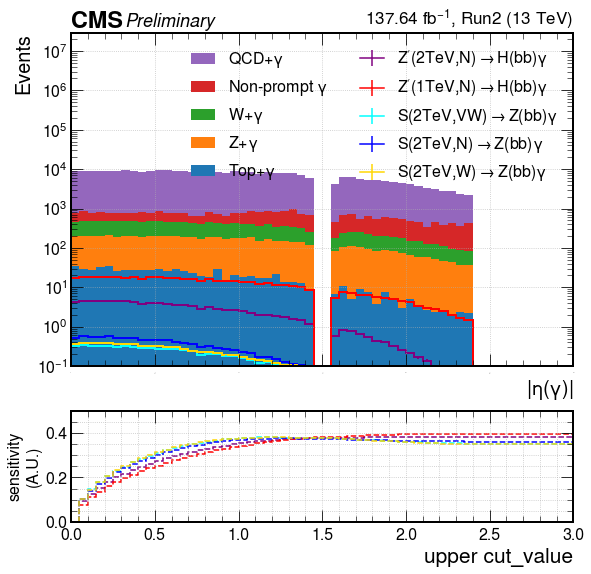

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1736809141.py:89: RuntimeWarning: invalid value encountered in scalar divide
  y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index])) for index in range(bins)]
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_

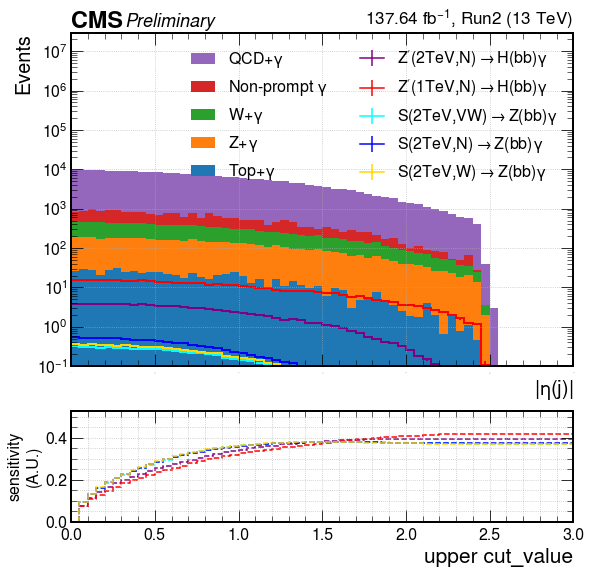

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1736809141.py:92: RuntimeWarning: invalid value encountered in scalar divide
  y = [ak.sum(cut_h[k][index:]) / np.sqrt(ak.sum(cut_bkg_h[index:])) for index in range(bins)]
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_

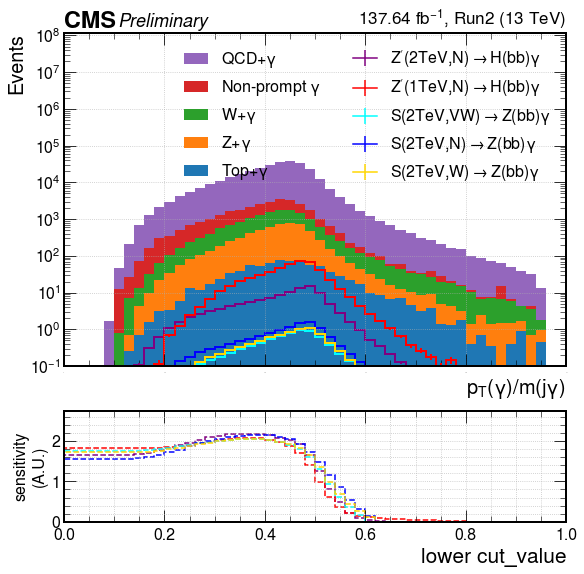

In [107]:
y='Run2'
full_cuts = """{
k: (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) 
for k in arrays
}"""

arrays={k: np.abs(events[y][k].photon_eta) for k in events[y] if k!='data'}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].photon_eta) < 1.4442) &", "")
    ), plot_name='optimize_eta_photon', x_name=r'$|\eta(\gamma)|$', x_max=3, x_min=0, bins=60, weight=weight[y], year=y
)

arrays={k: np.abs(events[y][k].AK8jet_eta) for k in events[y] if k!='data'}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].AK8jet_eta) < 2.4) &", "")
    ), plot_name='optimize_eta_jet', x_name=r'$|\eta(j)|$', x_max=3, x_min=0, bins=60, weight=weight[y], year=y
)

full_cuts = """{
k: (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] < 0.95)
for k in arrays
}"""

arrays={k: events[y][k].photon_pt/events[y][k]['photon+jet_mass'] for k in events[y] if k!='data'}
optimizing_plot(
    arrays, mode='greater', cuts=eval(
        full_cuts.replace("&\n(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)", "")
    ), plot_name='optimize_pt_over_mass', x_name=r'$p_T(\gamma)/m(j\gamma)$', x_max=1, x_min=0, bins=50, weight=weight[y], year=y, overflow=False
)

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1736809141.py:89: RuntimeWarning: invalid value encountered in scalar divide
  y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index])) for index in range(bins)]
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_

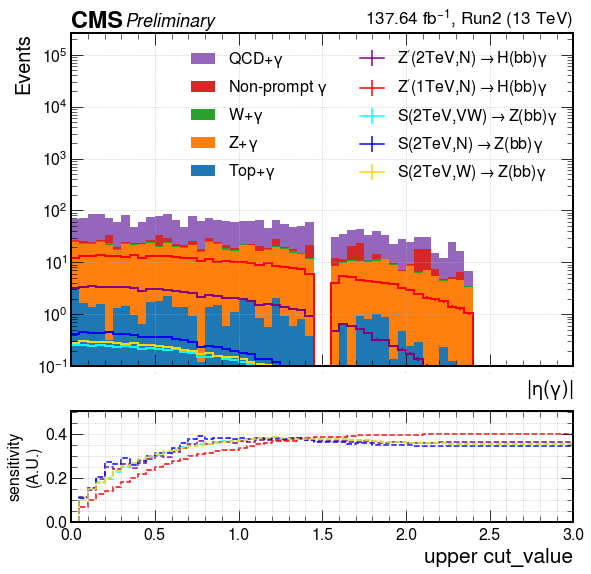

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1736809141.py:89: RuntimeWarning: invalid value encountered in scalar divide
  y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index])) for index in range(bins)]
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_

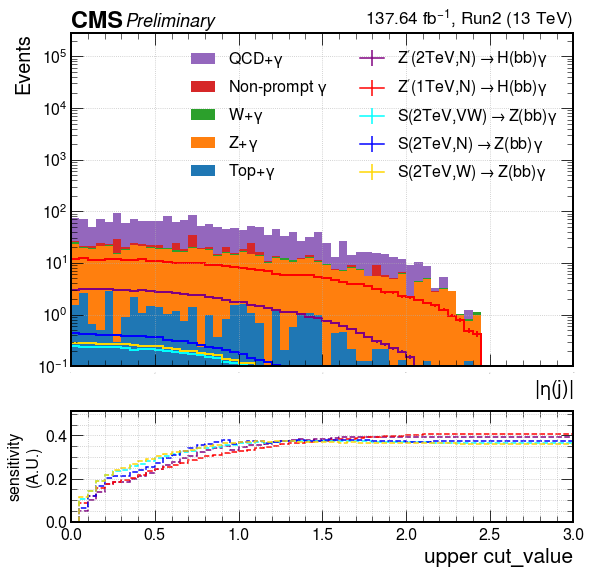

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1736809141.py:92: RuntimeWarning: invalid value encountered in scalar divide
  y = [ak.sum(cut_h[k][index:]) / np.sqrt(ak.sum(cut_bkg_h[index:])) for index in range(bins)]
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_

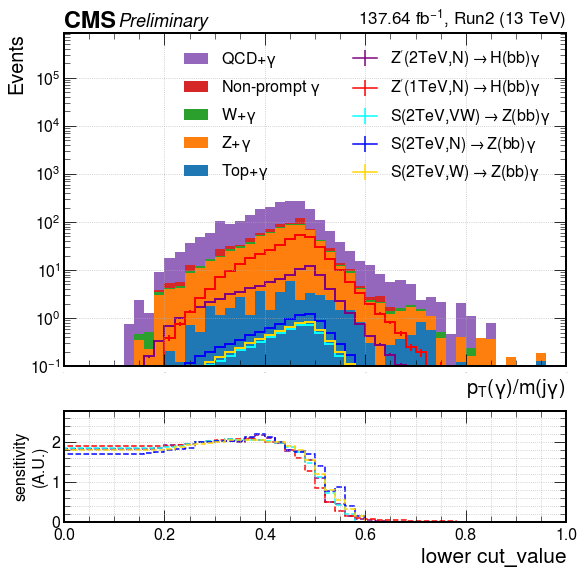

In [108]:
y='Run2'
full_cuts = """{
k: (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
(events[y][k].AK8jet_Xbb_tagger > 0.8)
for k in arrays
}"""

arrays={k: np.abs(events[y][k].photon_eta) for k in events[y] if k!='data'}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].photon_eta) < 1.4442) &", "")
    ), plot_name='optimize_eta_photon_tagger', x_name=r'$|\eta(\gamma)|$', x_max=3, x_min=0, bins=60, weight=weight[y], year=y
)

arrays={k: np.abs(events[y][k].AK8jet_eta) for k in events[y] if k!='data'}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].AK8jet_eta) < 2.4) &", "")
    ), plot_name='optimize_eta_jet_tagger', x_name=r'$|\eta(j)|$', x_max=3, x_min=0, bins=60, weight=weight[y], year=y
)

y='Run2'
full_cuts = """{
k: (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
(events[y][k].AK8jet_Xbb_tagger > 0.8) & 
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] < 0.95)
for k in arrays
}"""
arrays={k: events[y][k].photon_pt/events[y][k]['photon+jet_mass'] for k in events[y] if k!='data'}


optimizing_plot(
    arrays, mode='greater', cuts=eval(
        full_cuts.replace("(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &", "")
    ), plot_name='optimize_pt_over_mass_tagger', x_name=r'$p_T(\gamma)/m(j\gamma)$', x_max=1, x_min=0, bins=50, weight=weight[y], year=y, overflow=False
)


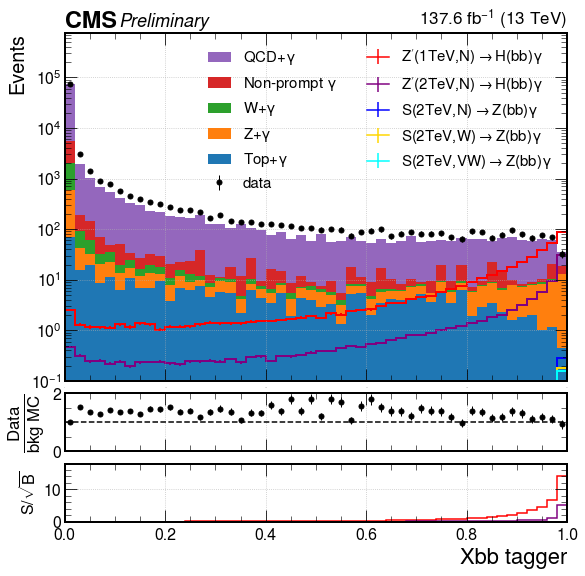

In [111]:

y = 'Run2'
full_cuts = {
k: (events[y][k]['AK8jet_particleNet_mass'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
for k in events[y]
}
arrays={k: events[y][k]['AK8jet_Xbb_tagger'][full_cuts[k]] for k in events[y]}
_weight={k: weight[y][k][full_cuts[k]] for k in weight[y]}
data_mc_compare_plot(arrays, plot_name='Xbb_tagger_with_cuts', x_name='Xbb tagger', bin_width=0.02, x_min=0, x_max=1, weight=_weight, year=y)

## Tagger ROCs

In [ ]:
from sklearn.metrics import roc_curve

def plot_ROC(tagger, sample_weight, y_label, sig_label, legend_location='best', year='Run2', plot_name='ROC'):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    plt.figure(figsize=(9,9))
    ax=plt.gca()
    #plt.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Work in Progress')

    plt.plot([plt.xlim()[0],plt.xlim()[1]], [0.01,0.01], linestyle="dashed", lw=2, color='gray')    
    for t, scores in tagger.items():
        fpr, tpr, _threshold = roc_curve(y_true=y_label, y_score=scores, sample_weight=sample_weight, pos_label=1)
        plt.plot(tpr, fpr, linestyle="solid", lw=2, label=t)
        index=np.where(fpr==min(fpr, key=lambda x:abs(x-0.01), ))[0]
        plt.plot([tpr[index], tpr[index]], [plt.ylim()[0], 0.01], linestyle="dashed", lw=2, color='gray')

    plt.xlim(0, 1)
    plt.ylim(3e-4, 0.3)
    x_major_locator=plt.MultipleLocator(0.1)
    #y_major_locator=MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel(f'{sig_label} efficiency', fontsize=22, ha='right', x=1)
    plt.ylabel('Background efficiency', fontsize=22, ha='right', y=1)
    plt.yscale('log')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.legend(loc=legend_location,frameon=False, fontsize=16)


    plt.savefig(f"plots/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
y='Run2'
sig_label='1000$\\to$H(bb)$\\gamma$'
channels = [i for i in events[y].keys() if i in BKG or i==sig_label]

tagger = {
    'Double b': ak.concatenate([events[y][k]['AK8jet_btagHbb'] for k in channels], axis=0),
    'DeepDoubleB': ak.concatenate([events[y][k]['AK8jet_btagDDBvLV2'] for k in channels], axis=0),
    'DeepAK8-MD Hbb vs. QCD': ak.concatenate([events[y][k]['AK8jet_deepTagMD_HbbvsQCD'] for k in channels], axis=0),
    'PNet-MD Xbb vs. others': ak.concatenate([events[y][k]['AK8jet_particleNetMD_Xbb'] for k in channels], axis=0),
    'PNet-MD Xbb vs. QCD': ak.concatenate([events[y][k]['AK8jet_particleNetMD_Xbb']/(events[y][k]['AK8jet_particleNetMD_Xbb']+events[y][k]['AK8jet_particleNetMD_QCD']) for k in channels], axis=0),
    'Xbb vs. others': ak.concatenate([events[y][k]['AK8jet_inclParTMDV2_probHbb'] for k in channels], axis=0), 
    'Xbb vs. QCD': ak.concatenate([events[y][k]['AK8jet_Xbb_tagger'] for k in channels], axis=0)
}
sample_weight = ak.concatenate([weight[y][k] for k in channels], axis=0)
signal_label = {
    k: (ak.ones_like(events[y][k]['photon_pt']) if '(bb)' in k else ak.zeros_like(events[y][k]['photon_pt']))
    for k in channels
}
y_label = ak.concatenate([signal_label[k] for k in channels], axis=0)

plot_ROC(tagger, sample_weight, y_label, sig_label, plot_name='ROC_Hbb')

In [ ]:
y='Run2'
sig_label='1000$\\to$Z(bb)$\\gamma$'
channels = [i for i in events[y].keys() if i in BKG or i==sig_label]

tagger = {
    'double b': ak.concatenate([events[y][k]['AK8jet_btagHbb'] for k in channels], axis=0),
    'deepDoubleB': ak.concatenate([events[y][k]['AK8jet_btagDDBvLV2'] for k in channels], axis=0),
    'DeepAK8-MD Hbb vs. QCD': ak.concatenate([events[y][k]['AK8jet_deepTagMD_HbbvsQCD'] for k in channels], axis=0),
    'PNet-MD Xbb vs. others': ak.concatenate([events[y][k]['AK8jet_particleNetMD_Xbb'] for k in channels], axis=0),
    'PNet-MD Xbb vs. QCD': ak.concatenate([events[y][k]['AK8jet_particleNetMD_Xbb']/(events[y][k]['AK8jet_particleNetMD_Xbb']+events[y][k]['AK8jet_particleNetMD_QCD']) for k in channels], axis=0),
    'GloParTv2 Xbb vs. others': ak.concatenate([events[y][k]['AK8jet_inclParTMDV2_probHbb'] for k in channels], axis=0), 
    'GloParTv2 Xbb vs. QCD': ak.concatenate([events[y][k]['AK8jet_Xbb_tagger'] for k in channels], axis=0)
}
sample_weight = ak.concatenate([weight[y][k] for k in channels], axis=0)
signal_label = {
    k: (ak.ones_like(events[y][k]['photon_pt']) if '(bb)' in k else ak.zeros_like(events[y][k]['photon_pt']))
    for k in channels
}
y_label = ak.concatenate([signal_label[k] for k in channels], axis=0)

plot_ROC(tagger, sample_weight, y_label, sig_label, plot_name='ROC_Zbb')

## Tagger SR optimization

In [64]:
def plot_2D_scatter(x, y, year, plot_name: str, x_name: str='SR1 cut', y_name: str='SR2 cut', weight=None, x_min=0, x_max=3000, y_min=0, y_max=3000):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid(visible=True, which='both')
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, lumi=round(LUMI[year], 1), llabel='Preliminary')


    ## plot
    #h_2D = bh.numpy.histogram2d(x, y, bins=[x_bins, y_bins], range=[[x_min, x_max], [y_min, y_max]], weights=weight)
    ax.scatter(x=x, y=y, s=100, c=weight, cmap='YlGn')
    for i, w in enumerate(weight):
        ax.annotate(text='%.1f'%w, xy=(x[i], y[i]), xytext=(x[i]-0.01, y[i]+0.006), fontsize=12)

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylabel(y_name, fontsize=22, ha='right', y=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis='both', which='major', labelsize=16)

    ## finalizing
    if not os.path.exists(f'./plots/optimize/{year}'):
        os.makedirs(f'./plots/optimize/{year}')
    plt.savefig(f"./plots/optimize/{year}/2D_{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [65]:
year='Run2'
for channel in events[year]:
    if 'H(bb)' not in channel:
        continue
    m = int(float(channel.split('TeV')[0].split('(')[1])*1000)
    x, y, significance = [], [], []
    width = ak.std(events[year][channel]['photon+jet_mass'])

    for cut1 in np.arange(0.7, 0.999, 0.02):
        cut1 = round(cut1, 2)
        for cut2 in np.arange(cut1+0.02, 0.999, 0.02):
            cut2 = round(cut2, 2)
            x.append(cut1)
            y.append(cut2)
            num_SR1 = {
                k: weight[year][k][(events[year][k]['AK8jet_particleNet_mass'] > 110) & (events[year][k]['AK8jet_particleNet_mass'] < 150) &
                (np.abs(events[year][k].photon_eta) < 1.4442) &
                (np.abs(events[year][k].AK8jet_eta) < 2.4) &
                (events[year][k].photon_pt/events[year][k]['photon+jet_mass'] > 0.35) &
                (events[year][k].AK8jet_Xbb_tagger >= cut1) &
                (events[year][k].AK8jet_Xbb_tagger < cut2) &
                (events[year][k]['photon+jet_mass'] > m-2*width) & 
                (events[year][k]['photon+jet_mass'] < m+2*width)
            ] for k in [channel, 'bkg']
            }
            num_SR2 = {
                k: weight[year][k][(events[year][k]['AK8jet_particleNet_mass'] > 110) & (events[year][k]['AK8jet_particleNet_mass'] < 150) &
                (np.abs(events[year][k].photon_eta) < 1.4442) &
                (np.abs(events[year][k].AK8jet_eta) < 2.4) &
                (events[year][k].photon_pt/events[year][k]['photon+jet_mass'] > 0.35) &
                (events[year][k].AK8jet_Xbb_tagger >= cut2) &
                (events[year][k].AK8jet_Xbb_tagger < 2) &
                (events[year][k]['photon+jet_mass'] > m-2*width) & 
                (events[year][k]['photon+jet_mass'] < m+2*width)
            ] for k in [channel, 'bkg']
            }

            combined_sensitivity = np.sqrt(
                ak.sum(num_SR1[channel])**2/(ak.sum(num_SR1['bkg'])+1) +
                ak.sum(num_SR2[channel])**2/(ak.sum(num_SR2['bkg'])+1)
            )
            if np.isnan(combined_sensitivity):
                print(f"{cut1}, {cut2}; S1: {num_SR1[channel]}, B1: {num_SR1['bkg']}; S2: {num_SR2[channel]}, B2: {num_SR2['bkg']}")
            significance.append(np.nan_to_num(combined_sensitivity, nan=0))
        print(f'Iteration finished: {cut1}')

    x, y, significance = np.array(x), np.array(y), np.array(significance)
    plot_2D_scatter(x=x, y=y, weight=significance, year=year, plot_name=f'optimize_tagger_H{m}',  x_min=0.68, x_max=1, y_min=0.7, y_max=1)


KeyError: 'bkg'

In [ ]:
year='Run2'
for m in [1000, 2000, 3000]:
    sig = str(m)+r'$\to$Z(bb)$\gamma$'
    x, y, significance = [], [], []
    width = ak.std(events[year][sig]['photon+jet_mass'], weight=weight[year][sig])

    for cut1 in np.arange(0.7, 0.999, 0.02):
        cut1 = round(cut1, 2)
        for cut2 in np.arange(cut1+0.02, 0.999, 0.02):
            cut2 = round(cut2, 2)
            x.append(cut1)
            y.append(cut2)
            num_SR1 = {
                k: weight[year][k][(events[year][k]['AK8jet_particleNet_mass'] > 80) & (events[year][k]['AK8jet_particleNet_mass'] < 110) &
                (np.abs(events[year][k].photon_eta) < 1.4442) &
                (np.abs(events[year][k].AK8jet_eta) < 2.4) &
                (events[year][k].photon_pt/events[year][k]['photon+jet_mass'] > 0.35) &
                (events[year][k].AK8jet_Xbb_tagger >= cut1) &
                (events[year][k].AK8jet_Xbb_tagger < cut2) &
                (events[year][k]['photon+jet_mass'] > m-2*width) & 
                (events[year][k]['photon+jet_mass'] < m+2*width)
            ] for k in [sig, 'data']
            }
            num_SR2 = {
                k: weight[year][k][(events[year][k]['AK8jet_particleNet_mass'] > 80) & (events[year][k]['AK8jet_particleNet_mass'] < 110) &
                (np.abs(events[year][k].photon_eta) < 1.4442) &
                (np.abs(events[year][k].AK8jet_eta) < 2.4) &
                (events[year][k].photon_pt/events[year][k]['photon+jet_mass'] > 0.35) &
                (events[year][k].AK8jet_Xbb_tagger >= cut2) &
                (events[year][k].AK8jet_Xbb_tagger < 2) &
                (events[year][k]['photon+jet_mass'] > m-2*width) & 
                (events[year][k]['photon+jet_mass'] < m+2*width)
            ] for k in [sig, 'data']
            }

            combined_sensitivity = np.sqrt(
                ak.sum(num_SR1[sig])**2/(ak.sum(num_SR1['data'])+1) +
                ak.sum(num_SR2[sig])**2/(ak.sum(num_SR2['data'])+1)
            )
            if np.isnan(combined_sensitivity):
                print(f"{cut1}, {cut2}; S1: {num_SR1[sig]}, B1: {num_SR1['data']}; S2: {num_SR2[sig]}, B2: {num_SR2['data']}")
            significance.append(np.nan_to_num(combined_sensitivity, nan=0))
        print(f'Iteration finished: {cut1}')

    x, y, significance = np.array(x), np.array(y), np.array(significance)
    plot_2D_scatter(x=x, y=y, weight=significance, year=year, plot_name=f'optimize_tagger_Z{m}', x_min=0.68, x_max=1, y_min=0.7, y_max=1)


# SR & CR

## signal efficiency

In [25]:
import glob, yaml, os
N0 = {'ZpToHG': {}, 'GluGluToZG': {}, 'GluGluToZG_5p6': {}, 'GluGluToZG_10p0': {}}
for folder in sum([glob.glob(f'/{base}/mc/*/{channel}/*') for channel in N0.keys()], []):
    channel = folder.split('/')[-2]
    mass = folder.split('/')[-1].split('M')[-1]
    if '_0p014' in mass:
        channel = 'GluGluToZG'
    elif '_5p6' in mass:
        channel = 'GluGluToZG_5p6'
    elif '_10p0' in mass:
        channel = 'GluGluToZG_10p0'
    mass = int(mass.split('_')[0])
    if mass == 600:
        continue
    mode = '_'.join(folder.split('/')[-4:-1])
    file = os.path.join(folder, f'{mode}.yaml')
    with open(file, 'r', encoding='utf-8') as f:
        stats = yaml.safe_load(f)
    if mass not in N0[channel]:
        N0[channel][mass] = stats['n_events']
    else:
        N0[channel][mass] += stats['n_events']

N0

{'ZpToHG': {1600: 450000,
  2200: 450000,
  800: 899000,
  2000: 450000,
  1000: 450000,
  900: 696000,
  3000: 450000,
  700: 1200000,
  1800: 446000,
  1400: 450000,
  3500: 450000,
  1200: 450000,
  2400: 450000,
  2600: 450000},
 'GluGluToZG': {800: 1839018,
  1800: 1080000,
  2600: 1091160,
  1400: 1080000,
  1600: 1080000,
  900: 1350000,
  2200: 1105950,
  700: 2731620,
  1200: 1170000,
  3500: 1130841,
  1000: 1260000,
  2400: 1100504,
  2000: 1098530,
  3000: 1098660},
 'GluGluToZG_5p6': {1600: 1080000,
  1800: 1080000,
  900: 1314870,
  1400: 1080000,
  3000: 1143410,
  2400: 1112445,
  2600: 1119018,
  1000: 1260000,
  2200: 1103225,
  800: 1800000,
  3500: 1096651,
  2000: 1125760,
  700: 2766824,
  1200: 1170000},
 'GluGluToZG_10p0': {800: 1872240,
  3000: 1109966,
  2200: 1119947,
  2600: 1187648,
  1600: 1080000,
  900: 1349000,
  3500: 1141314,
  1200: 1169080,
  1800: 1080000,
  2000: 1124830,
  1000: 1259072,
  700: 2795584,
  2400: 1140849,
  1400: 1080000}}

In [ ]:
def calculate_signal_efficiency(final_number, original_number, mode='H'):
    paired_arrays = zip(list(original_number.keys()), list(original_number.values()))
    sorted_pairs = sorted(paired_arrays, key=lambda x: x[0])
    mass, N0 = zip(*sorted_pairs)
    paired_arrays = zip(list(final_number.keys()), list(final_number.values()))
    sorted_pairs = sorted(paired_arrays, key=lambda x: x[0])
    mass, N = zip(*sorted_pairs)
    eff = np.array(N) / (np.array(N0) * (0.5792 if mode=='H' else 0.156/0.692))
    return {mass[i]: eff[i] for i in range(len(mass))}

def plot_signal_efficiency(efficiencies, year: str='Run2', plot_name: str='signal_efficiency', x_name: str=r'$\rm{m^{gen}_{resonance}}$ (GeV)', x_min=500, x_max=4000):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    ax=plt.gca()
    #plt.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, lumi=round(LUMI[year], 1))

    ## plot
    for i in efficiencies:
        if '1' in i:
            plt.errorbar(x=efficiencies[i].keys(), y=efficiencies[i].values(), linestyle='dashed', label=i)
        elif '2' in i:
            plt.errorbar(x=efficiencies[i].keys(), y=efficiencies[i].values(), linestyle='dotted', label=i)
        else:
            plt.errorbar(x=efficiencies[i].keys(), y=efficiencies[i].values(), linestyle='solid', label=i)
        #plt.scatter(x=efficiencies[i].keys(), y=efficiencies[i].values(), s=30, label=i)

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylabel(r'$\varepsilon\times A$', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=14)

    ## finalizing
    if not os.path.exists('../plots'):
        os.makedirs('../plots')
    plt.savefig(f"../plots/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

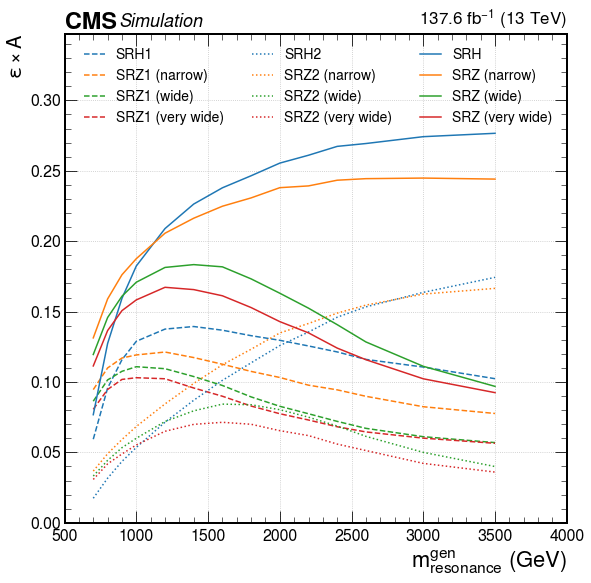

In [ ]:
y = 'Run2'
signal_efficiency = {}

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8) &
        (events[y][k].AK8jet_Xbb_tagger < 0.98)
    ) for k in events[y] if 'H(bb)' in k 
}
signal_efficiency['SRH1'] = calculate_signal_efficiency(N, N0['ZpToHG'])

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8) &
        (events[y][k].AK8jet_Xbb_tagger < 0.98)
    ) for k in events[y] if 'Z(bb)' in k and 'N' in k
}
signal_efficiency['SRZ1 (narrow)'] = calculate_signal_efficiency(N, N0['GluGluToZG'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8) &
        (events[y][k].AK8jet_Xbb_tagger < 0.98)
    ) for k in events[y] if 'Z(bb)' in k and ',W' in k
}
signal_efficiency['SRZ1 (wide)'] = calculate_signal_efficiency(N, N0['GluGluToZG_5p6'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8) &
        (events[y][k].AK8jet_Xbb_tagger < 0.98)
    ) for k in events[y] if 'Z(bb)' in k and 'VW' in k
}
signal_efficiency['SRZ1 (very wide)'] = calculate_signal_efficiency(N, N0['GluGluToZG_10p0'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.98)
    ) for k in events[y] if 'H(bb)' in k 
}
signal_efficiency['SRH2'] = calculate_signal_efficiency(N, N0['ZpToHG'])

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.98)
    ) for k in events[y] if 'Z(bb)' in k and 'N' in k
}
signal_efficiency['SRZ2 (narrow)'] = calculate_signal_efficiency(N, N0['GluGluToZG'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.98)
    ) for k in events[y] if 'Z(bb)' in k and ',W' in k
}
signal_efficiency['SRZ2 (wide)'] = calculate_signal_efficiency(N, N0['GluGluToZG_5p6'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.98)
    ) for k in events[y] if 'Z(bb)' in k and 'VW' in k
}
signal_efficiency['SRZ2 (very wide)'] = calculate_signal_efficiency(N, N0['GluGluToZG_10p0'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8)
    ) for k in events[y] if 'H(bb)' in k 
}
signal_efficiency['SRH'] = calculate_signal_efficiency(N, N0['ZpToHG'])

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8)
    ) for k in events[y] if 'Z(bb)' in k and 'N' in k
}
signal_efficiency['SRZ (narrow)'] = calculate_signal_efficiency(N, N0['GluGluToZG'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8)
    ) for k in events[y] if 'Z(bb)' in k and ',W' in k
}
signal_efficiency['SRZ (wide)'] = calculate_signal_efficiency(N, N0['GluGluToZG_5p6'], mode='Z')

N={
    int(float(k.split('TeV')[0].split('(')[1])*1000): ak.sum(
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8)
    ) for k in events[y] if 'Z(bb)' in k and 'VW' in k
}
signal_efficiency['SRZ (very wide)'] = calculate_signal_efficiency(N, N0['GluGluToZG_10p0'], mode='Z')

plot_signal_efficiency(signal_efficiency, plot_name='signal_efficiency')

## Data/MC comparison plots

In [ ]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'1000$\to$Z(bb)$\gamma$': 'blue',
    r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'2000$\to$Z(bb)$\gamma$': 'cyan',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

_events = {k: events[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) &
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    #(events[y][k]['AK8jet_Xbb_tagger'] > 0.8)
] for k in events[y] }
_weight = {k: weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & 
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    #(events[y][k]['AK8jet_Xbb_tagger'] > 0.8)
] for k in weight[y]}

arrays={k: _events[k]['photon+jet_mass'] for k in _events}
data_mc_compare_plot(arrays, plot_name='mjg_SRs', x_name=r'$m_{j\gamma}$ [GeV]', x_min=500, x_max=4000, bin_width=50, weight=_weight, year=y, overflow=False)

### CR

In [ ]:
y='Run2'
SIG_COLOR = {}

arrays = {k: events[y][k]['photon+jet_mass'][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
    ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) |
    (events[y][k]['AK8jet_particleNet_mass'] > 150)) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.8) &
    (events[y][k].AK8jet_Xbb_tagger < 0.98)
] for k in events[y]}
_weight = {k: weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
    ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) |
    (events[y][k]['AK8jet_particleNet_mass'] > 150)) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.8) &
    (events[y][k].AK8jet_Xbb_tagger < 0.98)
] for k in weight[y]}

data_mc_compare_plot(arrays, plot_name='resonance_mass_CR1', x_name=r'$m_{j\gamma}$ [GeV]', x_min=500, x_max=3000, bin_width=50, weight=_weight, year=y, overflow=False)

arrays = {k: events[y][k]['photon+jet_mass'][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
    ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) |
    (events[y][k]['AK8jet_particleNet_mass'] > 150)) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.98) &
    (events[y][k].AK8jet_Xbb_tagger < 2)
] for k in events[y]}
_weight = {k: weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
    ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) |
    (events[y][k]['AK8jet_particleNet_mass'] > 150)) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.98) &
    (events[y][k].AK8jet_Xbb_tagger < 2)
] for k in weight[y]}

data_mc_compare_plot(arrays, plot_name='resonance_mass_CR2', x_name=r'$m_{j\gamma}$ [GeV]', x_min=500, x_max=3000, bin_width=50, weight=_weight, year=y, overflow=False)

### SR

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: Ru

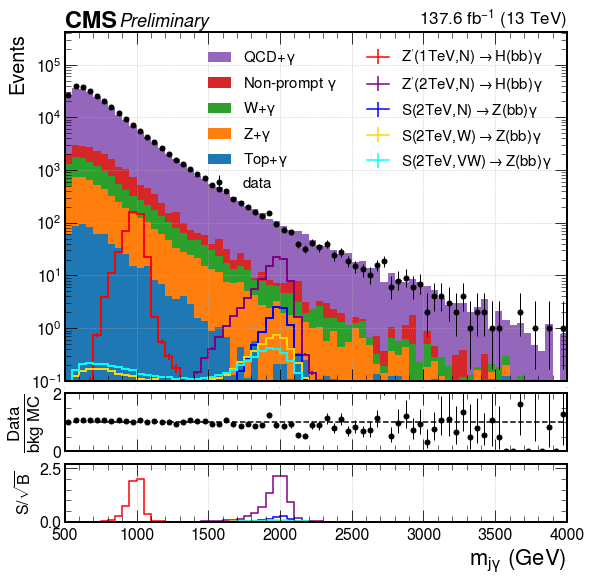

In [112]:
y='Run2'
_events = {k: events[y][k][
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_particleNet_mass > 80) & 
    (events[y][k].AK8jet_particleNet_mass < 150)
] for k in events[y]}
_weight = {k: weight[y][k][
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_particleNet_mass > 80) & 
    (events[y][k].AK8jet_particleNet_mass < 150)
] for k in weight[y]}

arrays={k: _events[k]['photon+jet_mass'] for k in _events}
data_mc_compare_plot(arrays, plot_name='mjg_without_tagger', x_name=r'$m_{j\gamma}$ (GeV)', x_min=500, x_max=4000, bin_width=50, weight=_weight, year=y, overflow=False, log_y=True)

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: Ru

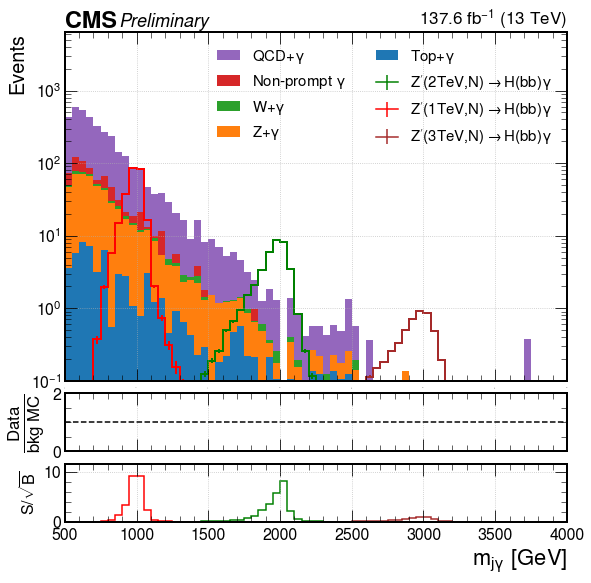

In [58]:
y='Run2'
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    #r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'$Z^\prime$(1TeV,N)$\to H(bb)\gamma$': 'red',
    #r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'$Z^\prime$(2TeV,N)$\to H(bb)\gamma$': 'green',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    r'$Z^\prime$(3TeV,N)$\to H(bb)\gamma$': 'brown',
    #r'3000_5p6$\to$Z(bb)$\gamma$': 'blue',
    #r'3000_10p0$\to$Z(bb)$\gamma$': 'gold',
}

_events = {k: events[y][k][
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.8) &
    (events[y][k].AK8jet_Xbb_tagger < 0.98)
] for k in events[y] if k!='data'}
_weight = {k: weight[y][k][
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.8) & 
    (events[y][k].AK8jet_Xbb_tagger < 0.98)
] for k in weight[y] if k!='data'}

arrays={k: _events[k]['photon+jet_mass'] for k in _events}
data_mc_compare_plot(arrays, plot_name='mjg_SRH1', x_name=r'$m_{j\gamma}$ [GeV]', x_min=500, x_max=4000, bin_width=50, weight=_weight, year=y, overflow=False, log_y=True)

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: Ru

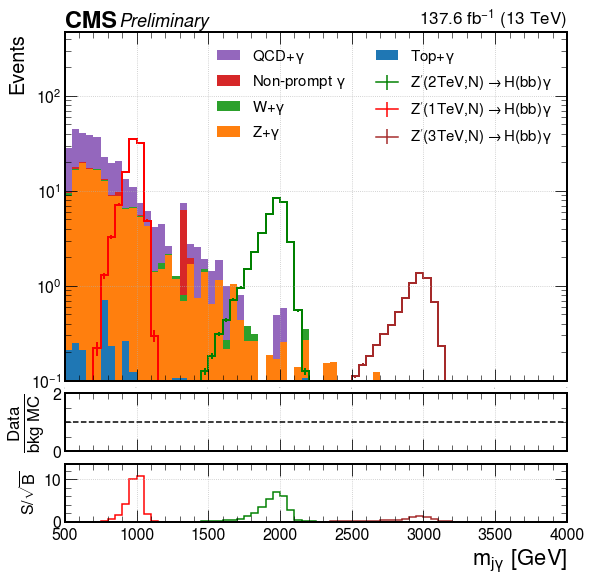

In [59]:
y='Run2'
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    #r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'$Z^\prime$(1TeV,N)$\to H(bb)\gamma$': 'red',
    #r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'$Z^\prime$(2TeV,N)$\to H(bb)\gamma$': 'green',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    r'$Z^\prime$(3TeV,N)$\to H(bb)\gamma$': 'brown',
    #r'3000_5p6$\to$Z(bb)$\gamma$': 'blue',
    #r'3000_10p0$\to$Z(bb)$\gamma$': 'gold',
}

_events = {k: events[y][k][
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.98)
] for k in events[y] if k!='data'}
_weight = {k: weight[y][k][
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.98)
] for k in weight[y] if k!='data'}

arrays={k: _events[k]['photon+jet_mass'] for k in _events}
data_mc_compare_plot(arrays, plot_name='mjg_SRH2', x_name=r'$m_{j\gamma}$ [GeV]', x_min=500, x_max=4000, bin_width=50, weight=_weight, year=y, overflow=False, log_y=True)

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: Ru

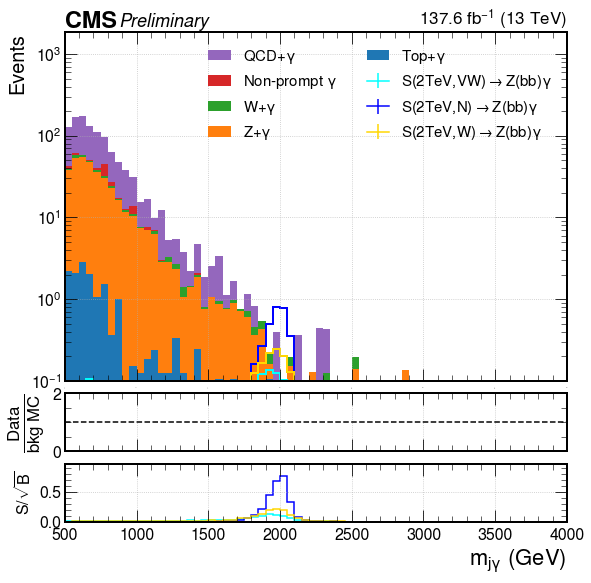

In [60]:
y='Run2'
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    #r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'S(2TeV,N)$\to Z(bb)\gamma$': 'blue',
    #r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'S(2TeV,W)$\to Z(bb)\gamma$': 'gold',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    r'S(2TeV,VW)$\to Z(bb)\gamma$': 'cyan',
    #r'3000_5p6$\to$Z(bb)$\gamma$': 'blue',
    #r'3000_10p0$\to$Z(bb)$\gamma$': 'gold',
}

_events = {k: events[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & 
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.8) &
    (events[y][k].AK8jet_Xbb_tagger < 0.98)
] for k in events[y] if k!='data'}
_weight = {k: weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & 
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.8) &
    (events[y][k].AK8jet_Xbb_tagger < 0.98)
] for k in weight[y] if k!='data'}


arrays={k: _events[k]['photon+jet_mass'] for k in _events}
data_mc_compare_plot(arrays, plot_name='mjg_SRZ1', x_name=r'$m_{j\gamma}$ (GeV)', x_min=500, x_max=4000, bin_width=50, weight=_weight, year=y, log_y=True)

/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:53: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_143567/1903999373.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_143567/1903999373.py:52: Ru

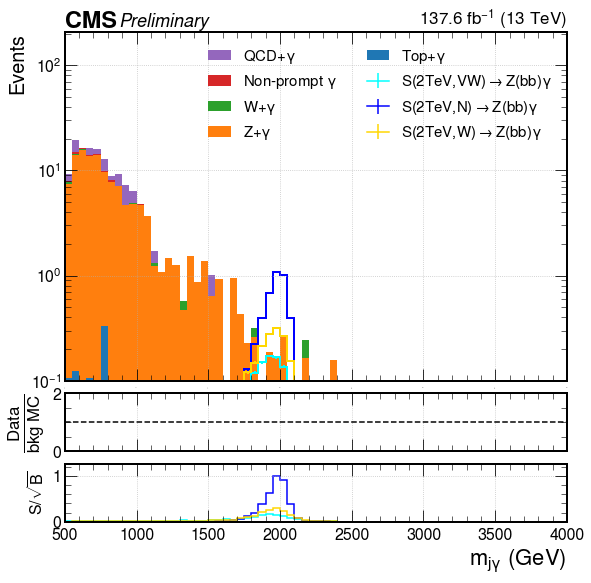

In [61]:
y='Run2'
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    #r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'S(2TeV,N)$\to Z(bb)\gamma$': 'blue',
    #r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'S(2TeV,W)$\to Z(bb)\gamma$': 'gold',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    r'S(2TeV,VW)$\to Z(bb)\gamma$': 'cyan',
    #r'3000_5p6$\to$Z(bb)$\gamma$': 'blue',
    #r'3000_10p0$\to$Z(bb)$\gamma$': 'gold',
}

_events = {k: events[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & 
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.98)
] for k in events[y] if k!='data'}
_weight = {k: weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & 
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
    (events[y][k].AK8jet_Xbb_tagger > 0.98)
] for k in weight[y] if k!='data'}


arrays={k: _events[k]['photon+jet_mass'] for k in _events}
data_mc_compare_plot(arrays, plot_name='mjg_SRZ2', x_name=r'$m_{j\gamma}$ (GeV)', x_min=500, x_max=4000, bin_width=50, weight=_weight, year=y, log_y=True)

### MC ratio

In [13]:
from matplotlib.cm import get_cmap

hep.style.use("CMS")

def mc_ratio_plot(arrays, weight, SR, plot_name: str, x_name: str, cuts=None, year='Run2', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, log_y=True,):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, fontsize=18, llabel='Simulation')
    
    
    ## analyze
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(v, weight=weight[k])
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var
        
    ## plot
    err = {}
    for k, h in individual['h'].items():
        err[k] = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err[k], label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax)

    CR = SR.replace('S', 'C')
    ratio = individual['h'][SR]/individual['h'][CR]
    ratio_err = ratio * np.sqrt((err[SR]/individual['h'][SR])**2 + (err[CR]/individual['h'][CR])**2)
    hep.histplot(ratio, bins=hist.axes[0].edges, yerr=ratio_err, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)

    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(1e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel(r'$\frac{SR}{CR}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
for SR in ['SR1', 'SR2']:
    arrays = {}
    _weight = {}
    _events = {k: events[y][k][
        (events[y][k]['photon-jet_deltaR'] > 1.1) & (
            ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 70)) |
            ((events[y][k]['AK8jet_particleNet_mass'] > 100) & (events[y][k]['AK8jet_particleNet_mass'] < 110)) |
            (events[y][k]['AK8jet_particleNet_mass'] > 145)
        ) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb > tagger_cut[SR][0]) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb < tagger_cut[SR][1])
    ] for k in BKG}
    arrays[SR.replace('S', 'C')] = ak.concatenate([_events[k]['photon+jet_mass'] for k in BKG], axis=0)

    weight_ = {k: weight[y][k][
        (events[y][k]['photon-jet_deltaR'] > 1.1) & (
            ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 70)) |
            ((events[y][k]['AK8jet_particleNet_mass'] > 100) & (events[y][k]['AK8jet_particleNet_mass'] < 110)) |
            (events[y][k]['AK8jet_particleNet_mass'] > 145)
        ) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb > tagger_cut[SR][0]) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb < tagger_cut[SR][1])
    ] for k in BKG}
    
    _weight[SR.replace('S', 'C')] = ak.concatenate([weight_[k] for k in BKG], axis=0)

    _events = {k: events[y][k][
        (events[y][k]['photon-jet_deltaR'] > 1.1) & 
        (events[y][k]['AK8jet_inclParTMDV2_probHbb'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 145) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb > tagger_cut[SR][0]) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb < tagger_cut[SR][1])
    ] for k in BKG}
    arrays[SR] = ak.concatenate([_events[k]['photon+jet_mass'] for k in BKG], axis=0)
 
    weight_ = {k: weight[y][k][
        (events[y][k]['photon-jet_deltaR'] > 1.1) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 145) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb > tagger_cut[SR][0]) &
        (events[y][k].AK8jet_inclParTMDV2_probHbb < tagger_cut[SR][1])
    ] for k in BKG}
    
    _weight[SR] = ak.concatenate([weight_[k] for k in BKG], axis=0)
    
    mc_ratio_plot(arrays, _weight, SR=SR, plot_name=f'{SR}_MC_ratio', x_name=r'$m_{j\gamma}$', year='Run2', bins=35, x_min=500, x_max=4000, density=False, overflow=True, underflow=False, log_y=True)

# Output

## Signal MC

In [17]:
mass_cut = {
    'Z': [80, 110],
    'H': [110, 150],
}

for y in ['2016', '2017', '2018', 'Run2']:
    for k in events[y]:
        if 'Z(bb)' not in k:
            continue
        mass, fatjet = k.split('$')[0], k.split('$')[2][0]

        cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k]['AK8jet_particleNet_mass'] > {mass_cut[fatjet][0]}) & 
        (events[y][k]['AK8jet_particleNet_mass'] < {mass_cut[fatjet][1]}) &
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8)
        )"""
        out_tree = {
            "fit_mass": events[y][k]['photon+jet_mass'][eval(cut)],
            "jet_mass": events[y][k]['AK8jet_particleNet_mass'][eval(cut)],
            "weight": weight[y][k][eval(cut)],
            "tagger": events[y][k]['AK8jet_Xbb_tagger'][eval(cut)],
            'event_No': events[y][k]['event_No.'][eval(cut)],
            #"mass_Zprime_JES_up": events[y][k]['photon+jet_mass_JES_jes_up'][eval(cut)],
            #"mass_Zprime_JES_down": events[y][k]['photon+jet_mass_JES_jes_down'][eval(cut)],
            #"mass_Zprime_JER_up": events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
            #"mass_Zprime_JER_down": events[y][k]['photon+jet_mass_JER_down'][eval(cut)],
            #'weight_PU_up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
            #'weight_PU_down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        }
        out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

        os.makedirs(f'./fit/input/{y}/{mass}', exist_ok=True)
        with uproot.recreate(f'./fit/input/{y}/{mass}/bbgamma_SR{fatjet}.root') as file:
            file['Events'] = out_tree

## Data

### SR

In [18]:
k = 'data'

for y in ['2016', '2017', '2018', 'Run2']:
    cut = """(
        (events[y][k]['AK8jet_particleNet_mass'] > 50) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
        (events[y][k].AK8jet_Xbb_tagger > 0.8)
    )"""

    sum=0
    _events = events[y][k][eval(cut)]
    dup_fit_mass = {}
    dup_jet_mass = {}
    dup_tagger = {}
    out_tree = {
        'fit_mass': [],
        'jet_mass': [],
        'weight': [],
        'tagger': [],
        'event_No': []
    }

    for i, n in enumerate(_events['event_No.']):
        if n in dup_fit_mass and (
            _events['photon+jet_mass'][i] == dup_fit_mass[n] and 
            _events['AK8jet_particleNet_mass'][i] == dup_jet_mass[n] and 
            abs(_events['AK8jet_Xbb_tagger'][i]-dup_tagger[n])<1e-3
        ):
            sum+=1
            continue
        dup_fit_mass[n] = _events['photon+jet_mass'][i]
        dup_jet_mass[n] = _events['AK8jet_particleNet_mass'][i]
        dup_tagger[n] = _events['AK8jet_Xbb_tagger'][i]
        out_tree['fit_mass'].append(_events['photon+jet_mass'][i])
        out_tree['jet_mass'].append(_events['AK8jet_particleNet_mass'][i])
        out_tree['weight'].append(1)
        out_tree['tagger'].append(_events['AK8jet_Xbb_tagger'][i])
        out_tree['event_No'].append(_events['event_No.'][i])

    out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})
    os.makedirs(f'./fit/input/{y}', exist_ok=True)
    with uproot.recreate(f'./fit/input/{y}/data.root') as file:
        file['Events'] = out_tree

### CR to SRH

In [36]:
y='Run2'
k='bkg'
a=ak.sum(weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) &
    (events[y][k]['AK8jet_particleNet_mass'] > 110) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
])
b=ak.sum(weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
        ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) | 
        (events[y][k]['AK8jet_particleNet_mass'] > 150)
    ) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
])

k = 'data'

cut = """(
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
        ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) | 
        (events[y][k]['AK8jet_particleNet_mass'] > 150)
    ) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
)"""

out_tree = {
    "fit_mass": events[y][k]['photon+jet_mass'][eval(cut)],
    "jet_mass": events[y][k]['AK8jet_particleNet_mass'][eval(cut)],
    "weight": np.ones_like(events[y][k]['photon+jet_mass'])[eval(cut)]*a/b,
    "tagger": events[y][k]['AK8jet_Xbb_tagger'][eval(cut)],
}

out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

if not os.path.exists(f'./fit/input/{y}'):
    os.makedirs(f'./fit/input/{y}')
with uproot.recreate(f'./fit/input/{y}/data_CR_to_SRH.root') as file:
    file['Events'] = out_tree

### CR to SRZ

In [37]:
y='Run2'
k='bkg'
a=ak.sum(weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) &
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 110) &
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
])
b=ak.sum(weight[y][k][
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
        ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) | 
        (events[y][k]['AK8jet_particleNet_mass'] > 150)
    ) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
])

k = 'data'

cut = """(
    (events[y][k]['photon-jet_deltaR'] > 1.1) & (
        ((events[y][k]['AK8jet_particleNet_mass'] > 50) & (events[y][k]['AK8jet_particleNet_mass'] < 80)) | 
        (events[y][k]['AK8jet_particleNet_mass'] > 150)
    ) & 
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
)"""

out_tree = {
    "fit_mass": events[y][k]['photon+jet_mass'][eval(cut)],
    "jet_mass": events[y][k]['AK8jet_particleNet_mass'][eval(cut)],
    "weight": np.ones_like(events[y][k]['photon+jet_mass'])[eval(cut)]*a/b,
    "tagger": events[y][k]['AK8jet_Xbb_tagger'][eval(cut)],
}

out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

if not os.path.exists(f'./fit/input/{y}'):
    os.makedirs(f'./fit/input/{y}')
with uproot.recreate(f'./fit/input/{y}/data_CR_to_SRZ.root') as file:
    file['Events'] = out_tree

## Background MC

In [38]:
k='bkg'

cut = """(
    (events[y][k]['photon-jet_deltaR'] > 1.1) &
    (events[y][k]['AK8jet_particleNet_mass'] > 80) & (events[y][k]['AK8jet_particleNet_mass'] < 150) &
    (np.abs(events[y][k].photon_eta) < 1.4442) &
    (np.abs(events[y][k].AK8jet_eta) < 2.4) &
    (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
)"""

out_tree = {
    "fit_mass": events[y][k]['photon+jet_mass'][eval(cut)],
    "jet_mass": events[y][k]['AK8jet_particleNet_mass'][eval(cut)],
    "weight": weight[y][k][eval(cut)],
    "tagger": events[y][k]['AK8jet_Xbb_tagger'][eval(cut)],
}

out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

if not os.path.exists(f'./fit/input/{y}'):
    os.makedirs(f'./fit/input/{y}')
with uproot.recreate(f'./fit/input/{y}/background_mc.root') as file:
    file['Events'] = out_tree